# Lesson 3b: Image Segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/mdasco/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/mdasco/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/images/0001TP_006750.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/mdasco/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/mdasco/.fastai/data/camvid/labels/0001TP_006750_P.png')]

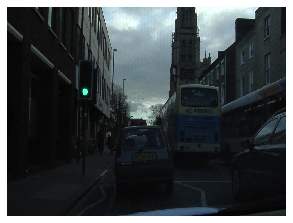

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

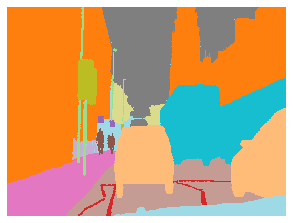

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs = 8
else:           bs = 2
print(f"using bs = {bs}, have {free}MB of GPU RAM free")

using bs = 2, have 3416MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

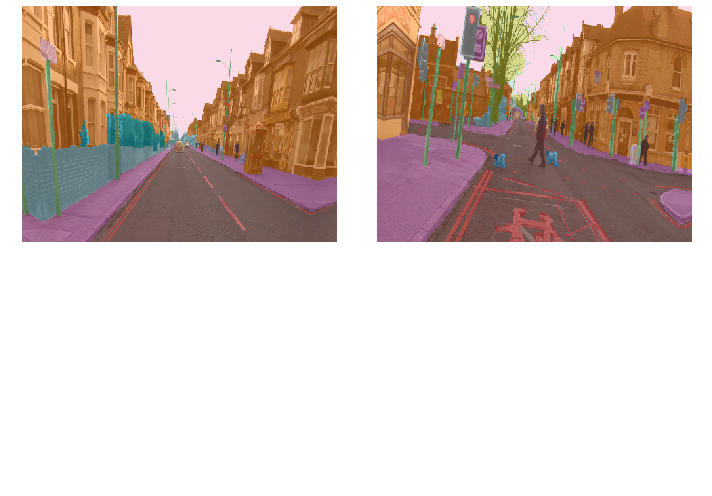

In [16]:
data.show_batch(1, figsize=(10, 7))

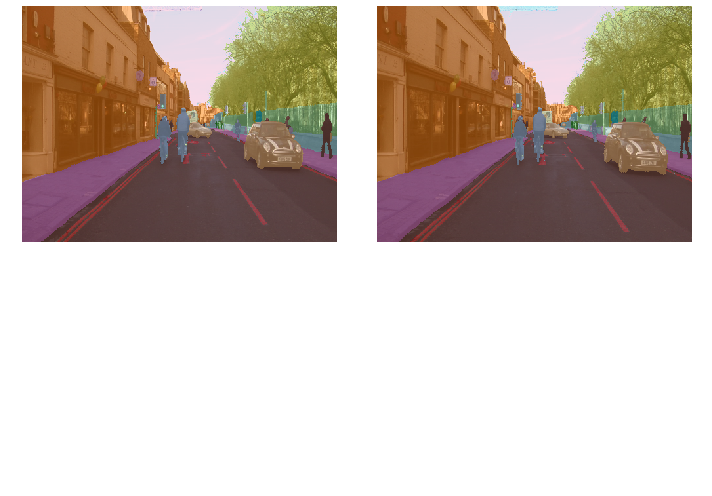

In [17]:
data.show_batch(1, figsize=(10, 7), ds_type=DatasetType.Valid)

## Model

In [18]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1) [mask] == target[mask]).float().mean()

In [19]:
metrics = acc_camvid
# metrics = accuracy

In [20]:
wd = 1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


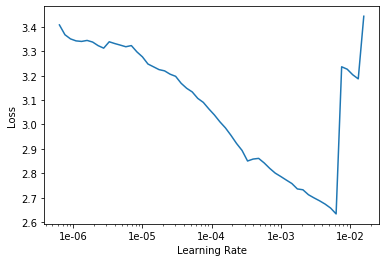

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.788268,0.634933,0.831411,04:08
1,0.680830,0.580349,0.853533,04:07
2,0.638697,0.578050,0.861391,04:07
3,0.566181,0.449363,0.870819,04:06
4,0.636244,0.501376,0.875418,04:04
5,0.609372,0.544784,0.869983,04:05
6,0.630436,0.471944,0.882040,04:05
7,1.031639,1.011137,0.678654,04:06
8,0.805900,0.922852,0.757016,04:02
9,0.688030,0.722814,0.793706,04:04


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

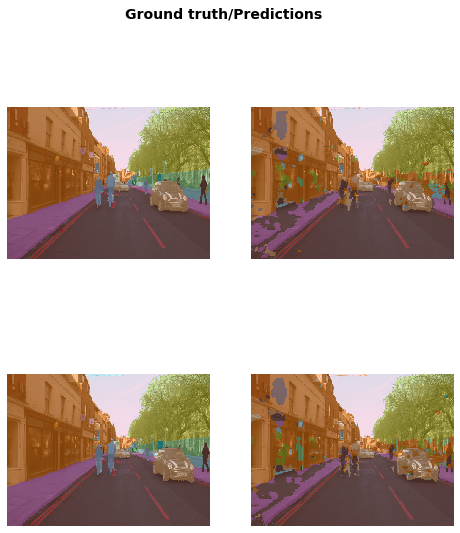

In [27]:
learn.show_results(rows=3, figsize=(8, 9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400, lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.654987,0.695478,0.800650,04:20
1,0.649932,0.686581,0.804700,04:21
2,0.650599,0.658688,0.809764,04:14
3,0.659767,0.707026,0.796806,04:14
4,0.601250,0.571907,0.836082,04:19
5,0.524193,0.476988,0.870044,04:24
6,0.503967,0.437802,0.886540,04:24
7,0.511966,0.416834,0.886795,04:23
8,0.487855,0.375006,0.898865,04:23
9,0.457497,0.449772,0.867108,04:20
